## Learning to Rank

Pointwise: One instance of the set is considered at a time, use any kind of classifier or regressor to predict how relevant it is in the current query. Use each points predicted relevance to order the set.

Pairwise: A pair of instances is chosen and the order of those two is predicted. Repeat this for each pair of the query to find the final order of the entire query.

Listwise: Many or all instances are considered at once. Try to find the optimal order.

- https://www.kaggle.com/code/prashant111/lightgbm-classifier-in-python
- https://www.kaggle.com/code/samratp/lightgbm-xgboost-catboost
- https://developer.nvidia.com/blog/learning-to-rank-with-xgboost-and-gpu/#:~:text=XGBoost%20is%20a%20widely%20used,descent%20using%20an%20objective%20function.
- https://medium.com/predictly-on-tech/learning-to-rank-using-xgboost-83de0166229d

In [1]:
#pip install catboost

In [2]:
import pandas as pd
import numpy as np

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers



import matplotlib.pyplot as plt
import seaborn as sns


2022-06-04 12:59:30.676140: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-04 12:59:30.676178: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# Data Preparation (Pre-processing)

In [3]:
import pandas as pd

df = pd.read_csv('hotels3.csv')
df.head()

,Hotel,Star,Rating,Reviews,Harga,Places Nearby,Facil + Akomod
0,Hotel Indonesia Kempinski Jakarta,5.0,8.9,4363,2.480.500,Nearby Places\n\nJia Jia - Grand Indonesia (De...,Food and Drinks\nA la carte breakfast\nA la ca...
1,"The Langham, Jakarta",5.0,8.8,238,3.823.600,Nearby Places\n\nPig Me Up! - Ashta District 8...,Food and Drinks\nA la carte dinner\nA la carte...
2,Manhattan Hotel,5.0,8.5,8405,6.231.500,Nearby Places\n\nJia Jia - Grand Indonesia (De...,Hotel Services\nBellhop\nConcierge\nMoney chan...
3,Aloft South Jakarta,4.0,8.9,424,762.300,Nearby Places\n\nSouthside Rooftop Bar & Loung...,Public Facilities\nParking\nCoffee shop\nEleva...
4,"The Mayflower, Jakarta - Marriott Executive Ap...",5.0,9.0,393,1.756.254,Nearby Places\n\nSudirman Plaza\nBusiness\n2 m...,Food and Drinks\nA la carte breakfast\nA la ca...


In [4]:
facilities_columns = ['Food and Drinks','Hotel Services','In-room Facilities', 'Business Facilities', 'Nearby Facilities', 'Public Facilities', 'General', 'Things to Do', 'Accessibilty', 'Connectivity', 'Transportation', 'Kids and Pets', 'Sports and Recreations', 'Shuttle Service']

facilities_columns.reverse()

for index , row in df.iterrows():
    
    # split per fasil and akomod
    arr = row['Facil + Akomod'].splitlines() 
    #iterate over fasil and akomod

    i = 0
    count = 0

    for  item in reversed(arr):
      count += 1
      if item in facilities_columns:
        df.at[index,item ] = count
        count = 0
        i += 1

In [5]:
df = df.fillna(0)

In [6]:
for index , row in df.iterrows():
    
    # split per fasil and akomod
    arr = row['Places Nearby'].splitlines() 
    
    #iterate over fasil and akomod

    i = 0
    count = 0
    
    for ind, item in enumerate(arr):
        itemsplits = item.split()
        for x in itemsplits:
            if x.isdigit():
                if itemsplits[1] == "km":
                    meters = itemsplits[0] * 1000
                else:
                    meters = itemsplits[0]
                    
                if meters.isdigit():
                    df.at[index,arr[ind-1]] = meters
                    #print(meters)

In [7]:
print(df.columns)

Index(['Hotel', 'Star', 'Rating', 'Reviews', 'Harga', 'Places Nearby',
       'Facil + Akomod', 'Shuttle Service', 'Sports and Recreations',
       'Kids and Pets', 'Transportation', 'Connectivity', 'Accessibilty',
       'Things to Do', 'General', 'Public Facilities', 'Nearby Facilities',
       'Business Facilities', 'In-room Facilities', 'Hotel Services',
       'Food and Drinks', 'Fast Food', 'Shop & Gifts', 'Business',
       'Transportation Hub', 'Casual Dining', 'Nightlife', 'Park & Zoo',
       'Public Service', 'Arts & Sciences', 'Fine Dining', 'Sport',
       'Quick Bites', 'Education', 'Street Food', 'Activity & Games', 'Cafe',
       'Entertainment', 'Food Court', 'Sight & Landmark'],
      dtype='object')


In [8]:
df.Harga = df['Harga'].str.replace('.','', regex = True)
df.Harga = df['Harga'].str.replace(',','.', regex = True)
df.Harga = df['Harga'].astype(float).astype(int)

df.Reviews = df['Reviews'].str.replace('.','', regex = True)
df.Reviews = df['Reviews'].str.replace(',','.', regex = True)
df.Reviews = df['Reviews'].astype(float).astype(int)

In [9]:
df = df.fillna(10000)

In [10]:
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')

In [11]:
df.dtypes

Hotel                     float64
Star                      float64
Rating                    float64
Reviews                     int64
Harga                       int64
Places Nearby             float64
Facil + Akomod            float64
Shuttle Service           float64
Sports and Recreations    float64
Kids and Pets             float64
Transportation            float64
Connectivity              float64
Accessibilty              float64
Things to Do              float64
General                   float64
Public Facilities         float64
Nearby Facilities         float64
Business Facilities       float64
In-room Facilities        float64
Hotel Services            float64
Food and Drinks           float64
Fast Food                   int64
Shop & Gifts                int64
Business                    int64
Transportation Hub          int64
Casual Dining               int64
Nightlife                   int64
Park & Zoo                  int64
Public Service              int64
Arts & Science

In [12]:
df.head()

,Hotel,Star,Rating,Reviews,Harga,Places Nearby,Facil + Akomod,Shuttle Service,Sports and Recreations,Kids and Pets,...,Fine Dining,Sport,Quick Bites,Education,Street Food,Activity & Games,Cafe,Entertainment,Food Court,Sight & Landmark
0,NaN,5.0,8.9,4363,2480500,NaN,NaN,2.0,3.0,4.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
1,NaN,5.0,8.8,238,3823600,NaN,NaN,0.0,2.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
2,NaN,5.0,8.5,8405,6231500,NaN,NaN,2.0,3.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
3,NaN,4.0,8.9,424,762300,NaN,NaN,0.0,2.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
4,NaN,5.0,9.0,393,1756254,NaN,NaN,2.0,3.0,7.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000


# Modelling

## Declare feature vector and target variable

In [13]:
# view summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Hotel                   0 non-null      float64
 1   Star                    89 non-null     float64
 2   Rating                  89 non-null     float64
 3   Reviews                 89 non-null     int64  
 4   Harga                   89 non-null     int64  
 5   Places Nearby           0 non-null      float64
 6   Facil + Akomod          0 non-null      float64
 7   Shuttle Service         89 non-null     float64
 8   Sports and Recreations  89 non-null     float64
 9   Kids and Pets           89 non-null     float64
 10  Transportation          89 non-null     float64
 11  Connectivity            89 non-null     float64
 12  Accessibilty            89 non-null     float64
 13  Things to Do            89 non-null     float64
 14  General                 89 non-null     floa

## Data Splitting

In [14]:
X = df[['Star','Reviews','Harga','Shuttle Service','Sports and Recreations', 'Kids and Pets', 'Transportation', 'Connectivity', 'Accessibilty', 'Things to Do', 'General', 'Public Facilities', 'Nearby Facilities', 'Business Facilities', 'In-room Facilities', 'Hotel Services', 'Food and Drinks', 'Fast Food', 'Shop & Gifts', 'Business', 'Transportation Hub', 'Casual Dining', 'Nightlife', 'Park & Zoo', 'Public Service', 'Arts & Sciences', 'Fine Dining', 'Sport', 'Quick Bites', 'Education', 'Street Food', 'Activity & Games', 'Cafe', 'Entertainment', 'Food Court', 'Sight & Landmark' ]]
y = df['Rating']

In [15]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
dev_X, val_X, dev_y, val_y = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Light GBM

In [16]:
#import lightgbm as lgb
#clf = lgb.lambdarank()
#clf.fit(X_train, y_train)

def run_lgb(X_train, X_test, y_train, y_test):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 40,
        "learning_rate" : 0.004,
        "bagging_fraction" : 0.6,
        "feature_fraction" : 0.6,
        "bagging_frequency" : 6,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "seed": 42
    }
    
    lgtrain = lgb.Dataset(X, label=y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgtrain, lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=150, 
                      evals_result=evals_result)
    
    #pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return model, evals_result #pred_test_y

In [17]:
model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y)
print("LightGBM Training Completed...")

[LightGBM] [Warning] Unknown parameter: bagging_frequency
Training until validation scores don't improve for 100 rounds


/home/gusanwa/.local/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/home/gusanwa/.local/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/home/gusanwa/.local/lib/python3.10/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_res

[150]	training's rmse: 0.215747	valid_1's rmse: 0.225934
[300]	training's rmse: 0.197047	valid_1's rmse: 0.195808
[450]	training's rmse: 0.183936	valid_1's rmse: 0.17601
[600]	training's rmse: 0.17322	valid_1's rmse: 0.16079
[750]	training's rmse: 0.16446	valid_1's rmse: 0.149243
[900]	training's rmse: 0.156643	valid_1's rmse: 0.140193
[1050]	training's rmse: 0.149939	valid_1's rmse: 0.132418
[1200]	training's rmse: 0.14468	valid_1's rmse: 0.127275
[1350]	training's rmse: 0.140144	valid_1's rmse: 0.122799
[1500]	training's rmse: 0.136336	valid_1's rmse: 0.119163
[1650]	training's rmse: 0.132807	valid_1's rmse: 0.115734
[1800]	training's rmse: 0.129869	valid_1's rmse: 0.113213
[1950]	training's rmse: 0.127009	valid_1's rmse: 0.111
[2100]	training's rmse: 0.124426	valid_1's rmse: 0.108922
[2250]	training's rmse: 0.12188	valid_1's rmse: 0.106944
[2400]	training's rmse: 0.119423	valid_1's rmse: 0.104686
[2550]	training's rmse: 0.117117	valid_1's rmse: 0.102577
[2700]	training's rmse: 0.114

In [18]:
y_pred = model.predict(X)
print(y_pred)

[8.77146568 8.77055613 8.60597962 8.61903903 8.92905607 8.65957379
 8.57714768 8.63329369 8.93054925 8.78620198 8.69894639 8.22525083
 8.21443887 8.71270823 8.6244002  8.72390828 8.61468971 8.76437303
 8.62475007 8.77484651 8.59561375 8.52068979 8.50971226 8.52370914
 8.33377036 8.72390828 8.86460039 8.50971226 8.75634119 8.47404563
 8.60960388 8.81411453 8.55749901 8.46260941 8.62039055 8.59893702
 8.63573172 8.80656337 8.47120586 8.63285081 8.56122591 8.54417456
 8.53325961 8.51704168 8.5739079  8.94533962 8.78072107 8.607573
 8.61719086 8.55345671 8.55918528 8.55918528 8.509857   8.02979684
 8.29651116 8.39085691 8.50185653 8.58038976 8.62127349 8.51678488
 8.68686153 8.53688261 8.50329099 8.56556464 8.66487174 8.31779864
 8.22960905 8.46880306 8.58853703 8.48274675 8.61584227 8.86056989
 8.69530981 8.33215794 8.44239868 8.4642393  8.875035   8.47980434
 8.18410472 8.60463172 8.42680453 8.14699807 8.6139382  8.00998833
 8.03228766 8.81289303 8.11326206 8.37840711 8.18399483]


In [19]:
'''
# feature importance
print("Features Importance...")
gain = model.feature_importance('Rating')
featureimp = pd.DataFrame({'Rating':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'Rating':100 * gain / gain.sum()}).sort_values('Rating', ascending=False)
print(featureimp[:50])
'''

'\n# feature importance\nprint("Features Importance...")\ngain = model.feature_importance(\'Rating\')\nfeatureimp = pd.DataFrame({\'Rating\':model.feature_name(), \n                   \'split\':model.feature_importance(\'split\'), \n                   \'Rating\':100 * gain / gain.sum()}).sort_values(\'Rating\', ascending=False)\nprint(featureimp[:50])\n'

## XGBoost























In [20]:
def run_xgb(train_X, train_y, val_X, val_y):
    params = {'objective': 'reg:linear', 
          'eval_metric': 'rmse',
          'eta': 0.001,
          'max_depth': 10, 
          'subsample': 0.6, 
          'colsample_bytree': 0.6,
          'alpha':0.001,
          'random_state': 42, 
          'silent': True}
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)
    
    watchlist = [(tr_data, 'train'), (va_data, 'valid')]
    
    model_xgb = xgb.train(params, tr_data, 2000, watchlist, maximize=False, early_stopping_rounds = 100, verbose_eval=100)
    
    #dtest = xgb.DMatrix(test_X)
    #xgb_pred_y = np.expm1(model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit))
    
    return  model_xgb #, xgb_pred_y,

In [21]:
# Training XGB
model_xgb = run_xgb(dev_X, dev_y, val_X, val_y)
print("XGB Training Completed...")

[13:00:09] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[13:00:09] WARNING: ../src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-rmse:8.05767	valid-rmse:8.02442


/home/gusanwa/.local/lib/python3.10/site-packages/xgboost/core.py:525: FutureWarning: Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.
  warnings.warn(


[100]	train-rmse:7.30820	valid-rmse:7.27506
[200]	train-rmse:6.62856	valid-rmse:6.59553
[300]	train-rmse:6.01245	valid-rmse:5.97954
[400]	train-rmse:5.45373	valid-rmse:5.42095
[500]	train-rmse:4.94660	valid-rmse:4.91398
[600]	train-rmse:4.48701	valid-rmse:4.45455
[700]	train-rmse:4.07046	valid-rmse:4.03819
[800]	train-rmse:3.69278	valid-rmse:3.66071
[900]	train-rmse:3.35055	valid-rmse:3.31870
[1000]	train-rmse:3.04032	valid-rmse:3.00873
[1100]	train-rmse:2.75918	valid-rmse:2.72786
[1200]	train-rmse:2.50454	valid-rmse:2.47354
[1300]	train-rmse:2.27344	valid-rmse:2.24279
[1400]	train-rmse:2.06461	valid-rmse:2.03434
[1500]	train-rmse:1.87519	valid-rmse:1.84535
[1600]	train-rmse:1.70393	valid-rmse:1.67456
[1700]	train-rmse:1.54870	valid-rmse:1.51975
[1800]	train-rmse:1.40799	valid-rmse:1.37923
[1900]	train-rmse:1.28146	valid-rmse:1.25310
[1999]	train-rmse:1.16785	valid-rmse:1.14025
XGB Training Completed...


## Catboost

In [22]:
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

In [23]:
cb_model.fit(dev_X, dev_y,
             eval_set=(val_X, val_y),
             use_best_model=True,
             verbose=50)

0:	learn: 0.2381980	test: 0.2711085	best: 0.2711085 (0)	total: 55.2ms	remaining: 27.6s


50:	learn: 0.1259337	test: 0.2309285	best: 0.2309285 (50)	total: 302ms	remaining: 2.66s
100:	learn: 0.0697623	test: 0.2200408	best: 0.2198964 (97)	total: 579ms	remaining: 2.29s
150:	learn: 0.0390883	test: 0.2162348	best: 0.2162348 (150)	total: 870ms	remaining: 2.01s
200:	learn: 0.0212079	test: 0.2142854	best: 0.2142854 (200)	total: 1.16s	remaining: 1.72s
250:	learn: 0.0112001	test: 0.2135251	best: 0.2135251 (250)	total: 1.47s	remaining: 1.46s
300:	learn: 0.0059961	test: 0.2131350	best: 0.2131350 (300)	total: 1.76s	remaining: 1.17s
350:	learn: 0.0032159	test: 0.2128927	best: 0.2128897 (349)	total: 2.06s	remaining: 873ms
400:	learn: 0.0017157	test: 0.2126824	best: 0.2126824 (400)	total: 2.35s	remaining: 580ms
450:	learn: 0.0009142	test: 0.2124871	best: 0.2124871 (450)	total: 2.7s	remaining: 294ms
499:	learn: 0.0004937	test: 0.2123726	best: 0.2123726 (499)	total: 3.06s	remaining: 0us

bestTest = 0.2123726103
bestIteration = 499



pred_test_cat = np.expm1(cb_model.predict(X))
print(pred_test_cat)

## Tensorflow Regression

In [24]:
df = df.drop(['Hotel', 'Places Nearby', 'Facil + Akomod'], axis=1)
df

,Star,Rating,Reviews,Harga,Shuttle Service,Sports and Recreations,Kids and Pets,Transportation,Connectivity,Accessibilty,...,Fine Dining,Sport,Quick Bites,Education,Street Food,Activity & Games,Cafe,Entertainment,Food Court,Sight & Landmark
0,5.0,8.9,4363,2480500,2.0,3.0,4.0,4.0,5.0,6.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
1,5.0,8.8,238,3823600,0.0,2.0,3.0,4.0,3.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
2,5.0,8.5,8405,6231500,2.0,3.0,3.0,7.0,6.0,8.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
3,4.0,8.9,424,762300,0.0,2.0,0.0,3.0,0.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
4,5.0,9.0,393,1756254,2.0,3.0,7.0,6.0,3.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,2.0,7.9,11026,385200,2.0,0.0,0.0,4.0,3.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
85,5.0,8.9,1511,2420000,2.0,0.0,0.0,8.0,3.0,8.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
86,4.0,7.8,517,688000,0.0,0.0,0.0,0.0,3.0,0.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000
87,4.0,8.4,2717,431250,2.0,3.0,0.0,5.0,4.0,3.0,...,10000,10000,10000,10000,10000,10000,10000,10000,10000,10000


In [25]:
df2 = df
df3 = df

## Data Preparation

In [26]:
train_dataset = df.sample(frac=1, random_state=0)
test_dataset = df.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Rating')
test_labels = test_features.pop('Rating')

## DNN Model

In [27]:
def build_and_compile_model(norm):
  
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
      ])

    model.compile(loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001))
    return model

## Tensorflow Normalizer

In [28]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

2022-06-04 13:00:57.174598: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-04 13:00:57.174671: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-04 13:00:57.174702: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gusanwa): /proc/driver/nvidia/version does not exist
2022-06-04 13:00:57.175289: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [29]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 36)               73        
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                2368      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 6,666
Trainable params: 6,593
Non-trainable params: 73
_________________________________________________________________


In [30]:
dnn_model.layers[1].kernel

<tf.Variable 'dense/kernel:0' shape=(36, 64) dtype=float32, numpy=
array([[-0.09036618,  0.07226716, -0.04520044, ..., -0.16623318,
        -0.1011817 ,  0.07405524],
       [ 0.22718848,  0.24439485,  0.00340153, ..., -0.17586458,
        -0.23093264,  0.15552507],
       [ 0.13822933,  0.11038731, -0.12940036, ...,  0.04662277,
         0.19851066,  0.13856448],
       ...,
       [-0.2221491 , -0.24466649, -0.03050257, ...,  0.21392722,
         0.10355158, -0.19254361],
       [ 0.1114267 ,  0.01779716, -0.17200041, ..., -0.22079644,
        -0.02261193, -0.18695861],
       [-0.0089418 ,  0.17149489, -0.18287608, ...,  0.19705136,
        -0.18850563,  0.12317656]], dtype=float32)>

In [31]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

In [32]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.108260,1.211578,95
96,0.110405,1.239488,96
97,0.100369,1.218683,97
98,0.086810,1.196578,98
99,0.098182,1.151814,99


In [33]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

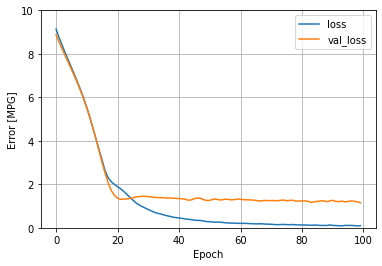

In [34]:
plot_loss(history)

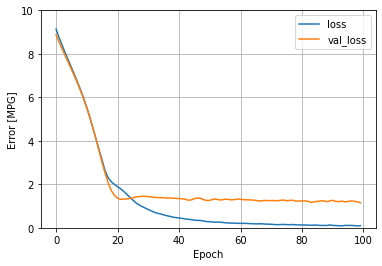

In [35]:
plot_loss(history)

In [36]:
def small_model(norm = normalizer):
  
    model = keras.Sequential([
      norm,
      layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001) ),
      layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
      layers.Dense(1)
      ])
    
    return model


def medium_model(norm = normalizer):
  
    model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001) ),
      layers.Dropout(0.5),
      layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001) ),
      layers.Dropout(0.5),
      layers.Dense(1)
      ])
    
    return model


def large_model(norm = normalizer):
  
    model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.5),
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.5),
      layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dropout(0.5),
      layers.Dense(1)
      ])
    
    return model

In [37]:
optimizer = tf.optimizers.Adam(learning_rate=0.001)

In [38]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.01)



In [39]:
def DNN_Pipeline (model):
    
    model.compile(optimizer= optimizer, loss='mean_absolute_error')
    
    history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler),
    verbose=0, epochs=100)
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    return hist.tail()

In [40]:
DNN_Pipeline(small_model())

,loss,val_loss,lr,epoch
95,0.024405,1.225735,0.000423,95
96,0.028221,1.229345,0.000419,96
97,0.023032,1.239291,0.000415,97
98,0.027813,1.233233,0.000411,98
99,0.025943,1.246620,0.000407,99


In [41]:
DNN_Pipeline(medium_model())

,loss,val_loss,lr,epoch
95,0.009255,1.232565,0.000172,95
96,0.008982,1.225804,0.000170,96
97,0.009757,1.223521,0.000169,97
98,0.009631,1.228518,0.000167,98
99,0.006998,1.230475,0.000165,99


In [42]:
DNN_Pipeline(large_model())

,loss,val_loss,lr,epoch
95,0.004992,1.227476,0.000070,95
96,0.004663,1.229705,0.000069,96
97,0.004500,1.229837,0.000069,97
98,0.003746,1.225935,0.000068,98
99,0.005220,1.228055,0.000067,99
